In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
!rm -rf cs472-housing-pricing/ data/ models/
!git clone https://github.com/devon65/cs472-housing-pricing.git
!mv cs472-housing-pricing/* .

Cloning into 'cs472-housing-pricing'...
remote: Enumerating objects: 136, done.
remote: Counting objects: 100% (136/136), done.
remote: Compressing objects: 100% (89/89), done.
remote: Total 136 (delta 52), reused 121 (delta 37), pack-reused 0
Receiving objects: 100% (136/136), 26.52 KiB | 3.79 MiB/s, done.
Resolving deltas: 100% (52/52), done.


In [0]:
!cp /content/gdrive/My\ Drive/BYU/Winter\ 2020/CS472/CS472\ Group\ Project/Data/cleaned/BLS_clean_data/MSA_master_clean.csv data/MSA_master_clean.csv
!cp /content/gdrive/My\ Drive/BYU/Winter\ 2020/CS472/CS472\ Group\ Project/Data/cleaned/Zillow/Metro_average_all.csv data/Metro_average_all.csv

# Small Auto MLP test

In [0]:
import models.machine_learning.auto_mlp

import importlib

models.machine_learning.auto_mlp = importlib.reload(models.machine_learning.auto_mlp)

In [3]:
!ls 

sample_data


In [31]:
model, acc, rmse, data = models.machine_learning.auto_mlp.train()

Adding 43-0000
Dataset loaded.
Dataset prepped.
Num training instances: 2070
Iteration 1, loss = 17116376316.85223389
Iteration 2, loss = 14587280333.14978027
Iteration 3, loss = 12475327772.39335823
Iteration 4, loss = 11721873306.51262474
Iteration 5, loss = 11550948159.56902122
Iteration 6, loss = 11267710147.70444870
Iteration 7, loss = 11044675908.92876816
Iteration 8, loss = 10761762262.38409233
Iteration 9, loss = 10314757112.33071518


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1342: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 10, loss = 9897323052.29252625
Iteration 11, loss = 9292860827.00304031
Iteration 12, loss = 8619541374.49461174
Iteration 13, loss = 7841112276.44583225
Iteration 14, loss = 6966486349.87634945
Iteration 15, loss = 6068728429.03168678
Iteration 16, loss = 5253711085.34710312
Iteration 17, loss = 4698662196.20499039
Iteration 18, loss = 4556670543.53735542
Iteration 19, loss = 4515032119.54217148
Iteration 20, loss = 4506814349.42827129
Iteration 21, loss = 4531260030.93567848
Iteration 22, loss = 4430496821.47317600
Iteration 23, loss = 4422868762.97444916
Iteration 24, loss = 4450770296.78678989
Iteration 25, loss = 4438491693.34784031
Iteration 26, loss = 4425721279.88058949
Iteration 27, loss = 4473477442.15517044
Iteration 28, loss = 4606590239.73290539
Iteration 29, loss = 4462519534.67125797
Iteration 30, loss = 4441541936.31722927
Iteration 31, loss = 4423741284.06666946
Iteration 32, loss = 4415950680.76172352
Iteration 33, loss = 4417367874.32230759
Iteration 34, lo

In [33]:
acc

0.26964078250083734

In [34]:
model.score(data[0], data[2])

0.4586598575148526

In [35]:
model.score(data[1], data[3])

0.26964078250083734

# LSTM Test

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import pandas as pd
import importlib
from torch.utils.data.sampler import SubsetRandomSampler

from IPython.core.ultratb import AutoFormattedTB

__ITB__ = AutoFormattedTB(mode = 'Verbose',color_scheme='LightBg', tb_offset = 1)

assert torch.cuda.is_available(), "You need to request a GPU from Runtime > Change Runtime"

In [0]:
import data.loader
data.loader = importlib.reload(data.loader)

In [0]:
class HousingDataset(Dataset):
  def __init__(self, occ_codes, columns):
    self.dataset = data.loader.HousingDataset(occ_codes)
    self.raw = [o for o in self.dataset.iterate_areas_with_window()]
    self.preloaded = [o[2].reset_index() for o in self.raw]
    self.columns = columns

  def __len__(self):
    return len(self.preloaded)

  def __getitem__(self, i):
    record = self.preloaded[i]
    feature_columns = record[self.columns]
    housing_index_column = record["HOUSING_INDEX"]
    
    seq = feature_columns.pct_change().to_numpy()[:-1]
    # import pdb; pdb.set_trace()
    tgt_prices = pd.concat([housing_index_column, housing_index_column.pct_change()], axis=1).to_numpy()
    tgt = [ tgt_prices[1][-1], tgt_prices[-2, 0], tgt_prices[-1, 0] ]

    return torch.Tensor(seq), torch.Tensor(tgt)
  

In [0]:
class HousingLSTM(nn.Module):
  def __init__(self):
    super(HousingLSTM, self).__init__()
    self.norm = nn.BatchNorm1d(4)
    self.lstm = nn.LSTM(3, 128, num_layers=2, batch_first=True)
    self.final = nn.Sequential(
          nn.ReLU(),
          nn.Linear(128, 1),
    )
  
  def forward(self, x):
    # import pdb; pdb.set_trace()
    h_t, c_t = None, None
    output, (h_t, c_t) = self.lstm(self.norm(x))
    linear_input = output[:, -1, :].squeeze(1)
    return self.final(linear_input)

    # outputs = []
    # for i, input_t in enumerate(x):
      # lstm_o, (h_t, c_t) = self.lstm(input_t)
      # output = self.final(lstm_o)
      # outputs.append(output)
    # outputs = torch.stack(outputs, 1)
    # return outputs

In [0]:
def train(model, optimizer, dataloader, loss_fn, num_epochs:int):
  len_loader = len(dataloader)
  loop = tqdm(total=len_loader * num_epochs, position=0)

  losses = []
  rmses = []

  for e in range(num_epochs):
    for i, (seq, target) in enumerate(dataloader):
      seq, target, last_year, this_year = seq.cuda(async=False), target[:,0].cuda(async=False).view(-1), target[:,1].cuda(async=False).view(-1), target[:,2].cuda(async=False).view(-1)
      # print(last_year, this_year)
      seq[seq != seq] = 0
      target[target != target] = 0
      last_year[last_year != last_year] = 0
      this_year[this_year != this_year] = last_year[this_year != this_year]

      optimizer.zero_grad()

      
      preds = model(seq).view(-1)
      # print(preds)
      loss = loss_fn(preds, target)
      

      # import pdb; pdb.set_trace()

      losses.append(loss.item())
      rmse = torch.sqrt(loss_fn(last_year * preds, this_year))
      rmses.append(rmse.item())

      rmse.backward()
      optimizer.step()

      loop.update(1)
      loop.set_description(f"Epoch {e}, it: {i}/{len_loader}; Loss: {loss.item()}; RMSE: {rmse.item()}")
  return losses, rmses

In [0]:
model = HousingLSTM()


In [267]:
dataset = HousingDataset(["43-0000"], [ "HOUSING_INDEX", "TOT_EMP", "H_MEDIAN" ]) 
# split to train val
validation_split = 0.9
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if True:
    np.random.seed(1337)
    np.random.shuffle(indices)
train_indices, valid_indices = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(valid_indices)

train_loader = DataLoader(
    dataset,
    batch_size=32,
    sampler=train_sampler)

valid_loader = DataLoader(
    dataset,
    batch_size=32,
    sampler=valid_sampler)

Adding 43-0000


In [0]:
optimizer = optim.Adam(model.cuda().parameters())
loss_fn = nn.MSELoss()

In [269]:
losses, rmses = train(model, optimizer, train_loader, loss_fn, 1000)

Epoch 999, it: 7/8; Loss: 0.9782816767692566; RMSE: 28624.333984375: 100%|██████████| 8000/8000 [14:49<00:00,  8.45it/s]   

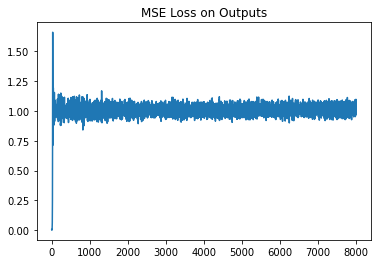

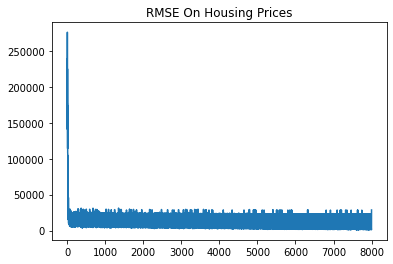

In [270]:
plt.title("MSE Loss on Outputs")
plt.plot(losses)
plt.show()

plt.title("RMSE On Housing Prices")
plt.plot(rmses)
plt.show()

In [271]:
dataset

In [0]:
def test(i):
  inp, o = dataset[i]
  inp[inp != inp] = 0
  pred = model(inp.unsqueeze(0).cuda())
  return ((o[1] * pred) - o[2]).item()

In [0]:
tests = [test(i) for i in range(20)]

In [292]:
print(tests)
print([type(t) for t in tests])
np.sqrt(np.mean(np.square(np.array(tests))))

[473.6015625, 6448.8984375, -3884.4609375, -5199.3203125, 30.7578125, 1808.640625, 1115.046875, -3758.4375, 4037.390625, 11724.34375, -1369.4375, 7627.53125, 5356.140625, 3610.2734375, -4869.0625, 5842.3828125, -3290.1328125, -1856.28125, 1668.671875, 3876.5390625]
[<class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>]


4733.061992796204

In [272]:
dataset[0]

(tensor([[    nan,     nan,     nan],
         [ 0.0172,  0.0490,  0.0325],
         [ 0.0634, -0.0196,  0.0191],
         [-0.1412,  0.0133,  0.0692]]),
 tensor([1.7235e-02, 9.7171e+04, 9.8336e+04]))

In [0]:
inp, o = dataset[0]
inp[inp != inp] = 0
# o = dataset[1]

In [276]:
inp

tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.0172,  0.0490,  0.0325],
        [ 0.0634, -0.0196,  0.0191],
        [-0.1412,  0.0133,  0.0692]])

In [0]:
pred = model(inp.unsqueeze(0).cuda())

In [278]:
pred

tensor([[1.0169]], device='cuda:0', grad_fn=<AddmmBackward>)

In [280]:
(o[1] * pred) - o[2]

tensor([[473.6016]], device='cuda:0', grad_fn=<SubBackward0>)

In [262]:
o

tensor([6.3400e-02, 9.8336e+04, 9.5096e+04])

In [263]:
o[1] * pred.item()

tensor(6741.5542)

In [264]:
pred.item()

0.06855614483356476

In [0]:
model_state = model.state_dict()
state = {
    "model": model_state,
    "occs": ["43-0000"],
    "cols": [ "HOUSING_INDEX", "TOT_EMP", "H_MEDIAN" ]
}

torch.save(state, f"/content/gdrive/My Drive/BYU/Winter 2020/CS472/CS472 Group Project/lstm_v1.mod")